# Week 1: N-gram Language Models
## BSc Computer Science - Natural Language Processing

This notebook provides hands-on experience with n-gram language models. All helper functions are provided at the top so you can focus on understanding the concepts.

**Learning Objectives:**
- Build and evaluate n-gram language models
- Apply smoothing techniques to handle unseen n-grams
- Calculate perplexity to evaluate model performance
- Work with real text data

## Helper Functions (Run this cell first, then ignore)

In [1]:
# Run this cell first - it contains all helper functions needed for the exercises

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
import random
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Educational color scheme
COLOR_CURRENT = '#FF6B6B'  # Red for current position
COLOR_CONTEXT = '#4ECDC4'  # Teal for context
COLOR_PREDICT = '#95E77E'  # Green for prediction
COLOR_NEUTRAL = '#E0E0E0'  # Gray for neutral elements

def download_text_data():
    """Download text data for analysis"""
    try:
        import nltk
        nltk.download('gutenberg', quiet=True)
        nltk.download('punkt', quiet=True)
        from nltk.corpus import gutenberg
        text = gutenberg.raw('carroll-alice.txt')
        print("Downloaded 'Alice in Wonderland' from NLTK Gutenberg corpus")
    except:
        # Fallback to a simple text if NLTK fails
        import requests
        try:
            response = requests.get('https://www.gutenberg.org/files/11/11-0.txt')
            text = response.text
            print("Downloaded 'Alice in Wonderland' from Project Gutenberg")
        except:
            # Ultimate fallback - use embedded sample
            text = """Alice was beginning to get very tired of sitting by her sister on the bank,
            and of having nothing to do. Once or twice she had peeped into the book her sister
            was reading, but it had no pictures or conversations in it. And what is the use of
            a book, thought Alice, without pictures or conversations? So she was considering in
            her own mind, as well as she could, for the hot day made her feel very sleepy and
            stupid, whether the pleasure of making a daisy-chain would be worth the trouble of
            getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran
            close by her. There was nothing so very remarkable in that; nor did Alice think it
            so very much out of the way to hear the Rabbit say to itself, Oh dear! Oh dear! I
            shall be late!"""
            print("Using embedded sample text")
    return text

def preprocess_text(text, lowercase=True):
    """Clean and tokenize text"""
    if lowercase:
        text = text.lower()
    # Remove special characters but keep punctuation
    text = re.sub(r'[^a-z0-9\s\.\,\!\?\-\'\"]+', '', text)
    # Tokenize
    tokens = text.split()
    return tokens

def generate_ngrams(tokens, n):
    """Generate n-grams from token list"""
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        ngrams.append(ngram)
    return ngrams

def build_ngram_model(tokens, n):
    """Build n-gram frequency model"""
    ngrams = generate_ngrams(tokens, n)
    model = defaultdict(Counter)
    
    for i in range(len(ngrams)):
        if n > 1:
            context = ngrams[i][:-1]
            word = ngrams[i][-1]
            model[context][word] += 1
        else:
            model[()][ngrams[i][0]] += 1
    
    return model

def calculate_probabilities(model, smoothing='none', alpha=1):
    """Convert frequency counts to probabilities with optional smoothing"""
    prob_model = {}
    vocab_size = len(set(word for context_counts in model.values() for word in context_counts))
    
    for context, word_counts in model.items():
        total = sum(word_counts.values())
        probs = {}
        
        if smoothing == 'add-one' or smoothing == 'laplace':
            for word, count in word_counts.items():
                probs[word] = (count + alpha) / (total + alpha * vocab_size)
        else:
            for word, count in word_counts.items():
                probs[word] = count / total
        
        prob_model[context] = probs
    
    return prob_model

def visualize_sliding_window(text, n=3, position=5):
    """Visualize n-gram sliding window"""
    tokens = text.split()[:15]  # Limit for visualization
    
    fig, ax = plt.subplots(figsize=(14, 3))
    
    # Draw tokens
    for i, token in enumerate(tokens):
        # Determine color based on position
        if i >= position and i < position + n:
            if i == position + n - 1:
                color = COLOR_PREDICT
            else:
                color = COLOR_CONTEXT
        else:
            color = COLOR_NEUTRAL
        
        rect = plt.Rectangle((i, 0), 0.9, 1, 
                            linewidth=2, 
                            edgecolor='black' if i >= position and i < position + n else 'gray',
                            facecolor=color,
                            alpha=0.7)
        ax.add_patch(rect)
        ax.text(i+0.45, 0.5, token[:8], ha='center', va='center', fontsize=9)
    
    # Draw window bracket
    if position + n <= len(tokens):
        ax.plot([position, position + n - 0.1], [-0.3, -0.3], 'k-', linewidth=2)
        ax.plot([position, position], [-0.3, -0.15], 'k-', linewidth=2)
        ax.plot([position + n - 0.1, position + n - 0.1], [-0.3, -0.15], 'k-', linewidth=2)
        ax.text(position + n/2 - 0.5, -0.5, f'{n}-gram window', ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlim(-0.5, len(tokens))
    ax.set_ylim(-0.7, 1.3)
    ax.axis('off')
    ax.set_title(f'Sliding Window for {n}-gram Generation (Position {position})', fontsize=12, pad=20)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_CONTEXT, label='Context'),
        Patch(facecolor=COLOR_PREDICT, label='Prediction Target'),
        Patch(facecolor=COLOR_NEUTRAL, label='Other Tokens')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_frequency_distribution(tokens, top_n=20):
    """Plot word frequency distribution"""
    word_counts = Counter(tokens)
    most_common = word_counts.most_common(top_n)
    
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(len(words)), counts, color='skyblue', edgecolor='navy')
    plt.xlabel('Words', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title(f'Top {top_n} Most Frequent Words', fontsize=12)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_ngram_probabilities(model, context, top_n=10):
    """Visualize probability distribution for given context"""
    if context not in model:
        print(f"Context '{' '.join(context)}' not found in model")
        return
    
    word_probs = model[context]
    sorted_probs = sorted(word_probs.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    words, probs = zip(*sorted_probs)
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(words)), probs, color='lightgreen', edgecolor='darkgreen')
    plt.xlabel('Next Word', fontsize=11)
    plt.ylabel('Probability', fontsize=11)
    plt.title(f"P(word | '{' '.join(context)}')", fontsize=12)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    
    # Add probability labels
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{prob:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def calculate_perplexity(model, test_tokens, n):
    """Calculate perplexity of model on test data"""
    test_ngrams = generate_ngrams(test_tokens, n)
    log_prob_sum = 0
    count = 0
    
    for ngram in test_ngrams:
        if n > 1:
            context = ngram[:-1]
            word = ngram[-1]
        else:
            context = ()
            word = ngram[0]
        
        if context in model and word in model[context]:
            prob = model[context][word]
            if prob > 0:
                log_prob_sum += np.log2(prob)
                count += 1
    
    if count == 0:
        return float('inf')
    
    avg_log_prob = log_prob_sum / count
    perplexity = 2 ** (-avg_log_prob)
    return perplexity

def generate_text(model, n, seed_text, length=20):
    """Generate text using n-gram model"""
    tokens = seed_text.lower().split()
    generated = tokens.copy()
    
    for _ in range(length):
        if n > 1:
            context = tuple(generated[-(n-1):])
        else:
            context = ()
        
        if context in model:
            # Sample from probability distribution
            words = list(model[context].keys())
            probs = list(model[context].values())
            
            # Normalize probabilities
            total = sum(probs)
            if total > 0:
                probs = [p/total for p in probs]
                next_word = np.random.choice(words, p=probs)
                generated.append(next_word)
            else:
                break
        else:
            # Fallback to random word if context not found
            all_words = [word for context_words in model.values() for word in context_words.keys()]
            if all_words:
                generated.append(random.choice(all_words))
            else:
                break
    
    return ' '.join(generated)

def compare_models(models_dict, test_tokens):
    """Compare different n-gram models"""
    results = []
    
    for name, (model, n) in models_dict.items():
        perplexity = calculate_perplexity(model, test_tokens, n)
        results.append({'Model': name, 'N': n, 'Perplexity': perplexity})
    
    df = pd.DataFrame(results)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Model'], df['Perplexity'], color=['#FF6B6B', '#4ECDC4', '#95E77E'][:len(df)])
    plt.xlabel('Model Type', fontsize=11)
    plt.ylabel('Perplexity (lower is better)', fontsize=11)
    plt.title('Model Performance Comparison', fontsize=12)
    
    # Add value labels
    for bar, perp in zip(bars, df['Perplexity']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{perp:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return df

def visualize_smoothing_effect(original_probs, smoothed_probs, title='Smoothing Effect'):
    """Compare probability distributions before and after smoothing"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original distribution
    words1 = list(original_probs.keys())[:15]
    probs1 = [original_probs[w] for w in words1]
    
    ax1.bar(range(len(words1)), probs1, color='lightblue', edgecolor='blue')
    ax1.set_xlabel('Words', fontsize=10)
    ax1.set_ylabel('Probability', fontsize=10)
    ax1.set_title('Original Distribution', fontsize=11)
    ax1.set_xticks(range(len(words1)))
    ax1.set_xticklabels(words1, rotation=45, ha='right', fontsize=8)
    
    # Smoothed distribution
    words2 = list(smoothed_probs.keys())[:15]
    probs2 = [smoothed_probs[w] for w in words2]
    
    ax2.bar(range(len(words2)), probs2, color='lightgreen', edgecolor='green')
    ax2.set_xlabel('Words', fontsize=10)
    ax2.set_ylabel('Probability', fontsize=10)
    ax2.set_title('After Add-One Smoothing', fontsize=11)
    ax2.set_xticks(range(len(words2)))
    ax2.set_xticklabels(words2, rotation=45, ha='right', fontsize=8)
    
    plt.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# ========================================
# STORY GENERATION HELPER FUNCTIONS
# ========================================

def get_story_starters():
    """Return Alice-style story starters"""
    starters = [
        "alice found herself",
        "suddenly a",
        "the white rabbit",
        "in the garden",
        "down the rabbit",
        "the queen of",
        "once upon a",
        "there was a",
        "alice wondered if",
        "the cheshire cat"
    ]
    return starters

def ensure_sentence_ending(text):
    """Ensure text ends with proper punctuation"""
    text = text.strip()
    if text and text[-1] not in '.!?':
        # Add appropriate ending based on content
        if 'who' in text or 'what' in text or 'where' in text or 'when' in text or 'why' in text or 'how' in text:
            text += '?'
        elif any(word in text.lower() for word in ['oh', 'ah', 'hurray', 'alas']):
            text += '!'
        else:
            text += '.'
    return text

def generate_sentence(model, n, starter=None, max_length=20):
    """Generate a complete sentence"""
    if starter is None:
        # Pick random starter from model contexts
        contexts = list(model.keys())
        if contexts:
            starter_context = random.choice(contexts)
            starter = ' '.join(starter_context) if starter_context else ""
    
    # Generate until we hit punctuation or max length
    generated = generate_text(model, n, starter, max_length)
    
    # Find first sentence ending
    for punct in ['.', '!', '?']:
        if punct in generated:
            idx = generated.index(punct)
            generated = generated[:idx+1]
            break
    
    return ensure_sentence_ending(generated)

def generate_paragraph(model, n, starter=None, sentences=4):
    """Generate a paragraph with multiple sentences"""
    paragraph = []
    current_starter = starter
    
    for i in range(sentences):
        sentence = generate_sentence(model, n, current_starter, max_length=25)
        paragraph.append(sentence)
        
        # Use end of previous sentence as context for next
        words = sentence.lower().split()
        if len(words) >= n-1:
            current_starter = ' '.join(words[-(n-1):])
        else:
            current_starter = None
    
    return ' '.join(paragraph)

def get_character_names(model):
    """Extract likely character names from model"""
    # Common Alice character patterns
    character_words = ['alice', 'rabbit', 'queen', 'king', 'hatter', 'cat', 'mouse', 
                       'duchess', 'caterpillar', 'dormouse', 'march', 'turtle', 'gryphon']
    
    characters = []
    for context_dict in model.values():
        for word in context_dict.keys():
            if word.lower() in character_words:
                characters.append(word.capitalize())
    
    return list(set(characters))

def generate_dialogue(model, n, character="Alice", emotion="said"):
    """Generate dialogue for a character"""
    # Generate what the character might say
    starters = ["the", "i", "you", "what", "oh", "how", "why", "but"]
    starter = random.choice(starters)
    
    dialogue = generate_sentence(model, n, starter, max_length=15)
    
    # Clean up dialogue
    dialogue = dialogue.strip()
    if dialogue and dialogue[0].islower():
        dialogue = dialogue[0].upper() + dialogue[1:]
    
    # Format with character attribution
    return f'"{dialogue}" {emotion} {character}.'

def create_story_template():
    """Provide story structure templates"""
    templates = {
        "adventure": {
            "beginning": ["alice found herself", "suddenly alice saw", "one day alice"],
            "middle": ["but then", "surprisingly", "without warning"],
            "climax": ["at last", "finally", "in the end"],
            "ending": ["and so alice", "after that alice", "alice learned that"]
        },
        "nonsense": {
            "beginning": ["in a world where", "there once was", "nobody expected"],
            "middle": ["which meant that", "therefore the", "causing the"],
            "climax": ["until suddenly", "when at last", "but then"],
            "ending": ["and that is why", "which explains", "proving that"]
        },
        "dream": {
            "beginning": ["alice dreamed", "in her dream", "she imagined"],
            "middle": ["everything changed when", "the scene shifted to", "then she found"],
            "climax": ["suddenly she realized", "it became clear that", "she understood"],
            "ending": ["she woke up", "and then alice", "it was all"]
        }
    }
    return templates

def visualize_story_structure(story):
    """Visualize story statistics and structure"""
    sentences = re.split(r'[.!?]+', story)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    # Calculate statistics
    sentence_lengths = [len(s.split()) for s in sentences]
    words = story.lower().split()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Sentence length over time
    ax1.plot(range(len(sentence_lengths)), sentence_lengths, 'o-', color='steelblue', linewidth=2)
    ax1.set_xlabel('Sentence Number')
    ax1.set_ylabel('Words per Sentence')
    ax1.set_title('Story Pacing (Sentence Length)')
    ax1.grid(True, alpha=0.3)
    
    # Word frequency
    word_freq = Counter(words)
    common_words = word_freq.most_common(15)
    words_list, counts = zip(*common_words)
    ax2.barh(range(len(words_list)), counts, color='coral')
    ax2.set_yticks(range(len(words_list)))
    ax2.set_yticklabels(words_list)
    ax2.set_xlabel('Frequency')
    ax2.set_title('Most Common Words')
    
    # Sentence length distribution
    ax3.hist(sentence_lengths, bins=10, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    ax3.set_xlabel('Sentence Length (words)')
    ax3.set_ylabel('Count')
    ax3.set_title('Sentence Length Distribution')
    ax3.axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(sentence_lengths):.1f}')
    ax3.legend()
    
    # Story statistics
    stats_text = f"""Story Statistics:
    
Total Words: {len(words)}
Total Sentences: {len(sentences)}
Avg Words/Sentence: {np.mean(sentence_lengths):.1f}
Longest Sentence: {max(sentence_lengths)} words
Shortest Sentence: {min(sentence_lengths)} words
Unique Words: {len(set(words))}
Vocabulary Richness: {len(set(words))/len(words):.2%}"""
    
    ax4.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax4.axis('off')
    
    plt.suptitle('Story Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def generate_full_story(model, n, paragraphs=5, style="adventure", title="An N-gram Adventure"):
    """Generate a complete short story"""
    templates = create_story_template()
    template = templates.get(style, templates["adventure"])
    
    story = []
    story.append(f"**{title}**\n")
    
    # Beginning
    starter = random.choice(template["beginning"])
    story.append(generate_paragraph(model, n, starter, sentences=3))
    
    # Middle paragraphs
    for i in range(paragraphs - 2):
        if i % 2 == 0:
            starter = random.choice(template["middle"])
        else:
            # Add some dialogue
            characters = get_character_names(model)
            if characters:
                character = random.choice(characters)
                dialogue = generate_dialogue(model, n, character)
                story.append(dialogue)
        story.append(generate_paragraph(model, n, starter, sentences=4))
    
    # Climax
    starter = random.choice(template["climax"])
    story.append(generate_paragraph(model, n, starter, sentences=3))
    
    # Ending
    starter = random.choice(template["ending"])
    story.append(generate_paragraph(model, n, starter, sentences=2))
    
    return '\n\n'.join(story)

def compare_story_styles(model, n):
    """Generate and compare stories in different styles"""
    styles = ["adventure", "nonsense", "dream"]
    stories = {}
    
    for style in styles:
        print(f"Generating {style} story...")
        stories[style] = generate_full_story(model, n, paragraphs=3, style=style, 
                                            title=f"A {style.capitalize()} Tale")
    
    return stories

# ========================================
# SHAKESPEARE SONNET GENERATION HELPERS
# ========================================

def download_shakespeare_sonnets():
    """Download Shakespeare's sonnets"""
    try:
        import nltk
        nltk.download('gutenberg', quiet=True)
        from nltk.corpus import gutenberg
        # Try to get Shakespeare from gutenberg
        text = gutenberg.raw('shakespeare-hamlet.txt')  # Using Hamlet as fallback
        print("Downloaded Shakespeare text from NLTK Gutenberg corpus")
    except:
        try:
            import requests
            # Download Shakespeare's sonnets from Project Gutenberg
            response = requests.get('https://www.gutenberg.org/files/1041/1041-0.txt')
            text = response.text
            print("Downloaded Shakespeare's Sonnets from Project Gutenberg")
        except:
            # Fallback - embed a few sonnets
            text = """Shall I compare thee to a summer's day?
Thou art more lovely and more temperate:
Rough winds do shake the darling buds of May,
And summer's lease hath all too short a date:
Sometime too hot the eye of heaven shines,
And often is his gold complexion dimm'd;
And every fair from fair sometime declines,
By chance, or nature's changing course untrimm'd;
But thy eternal summer shall not fade,
Nor lose possession of that fair thou ow'st;
Nor shall death brag thou wander'st in his shade,
When in eternal lines to time thou grow'st:
So long as men can breathe, or eyes can see,
So long lives this, and this gives life to thee.

When, in disgrace with fortune and men's eyes,
I all alone beweep my outcast state,
And trouble deaf heaven with my bootless cries,
And look upon myself, and curse my fate,
Wishing me like to one more rich in hope,
Featured like him, like him with friends possessed,
Desiring this man's art, and that man's scope,
With what I most enjoy contented least;
Yet in these thoughts myself almost despising,
Haply I think on thee, and then my state,
Like to the lark at break of day arising
From sullen earth, sings hymns at heaven's gate;
For thy sweet love remembered such wealth brings
That then I scorn to change my state with kings."""
            print("Using embedded Shakespeare sonnets")
    return text

def get_rhyme_words(model, word):
    """Find words that might rhyme based on endings"""
    if not word:
        return []
    
    # Simple rhyme detection based on endings
    endings = [word[-3:], word[-2:], word[-1:]]  # Try different ending lengths
    rhyme_candidates = []
    
    for context_dict in model.values():
        for candidate in context_dict.keys():
            for ending in endings:
                if len(candidate) > len(ending) and candidate.endswith(ending) and candidate != word:
                    rhyme_candidates.append(candidate)
                    break
    
    return list(set(rhyme_candidates))[:10]  # Return up to 10 rhyme candidates

def count_syllables(word):
    """Approximate syllable count (simple heuristic)"""
    word = word.lower()
    vowels = "aeiou"
    syllable_count = 0
    previous_was_vowel = False
    
    for char in word:
        is_vowel = char in vowels
        if is_vowel and not previous_was_vowel:
            syllable_count += 1
        previous_was_vowel = is_vowel
    
    # Adjust for silent e
    if word.endswith('e') and syllable_count > 1:
        syllable_count -= 1
    
    # Ensure at least one syllable
    return max(1, syllable_count)

def generate_iambic_line(model, n, target_syllables=10):
    """Generate line approximating iambic pentameter (10 syllables)"""
    max_attempts = 50
    
    for _ in range(max_attempts):
        # Start with common Shakespeare words
        starters = ["shall", "when", "but", "for", "if", "though", "yet", "and", "thy", "thou"]
        starter = random.choice(starters)
        
        # Generate text
        line = generate_text(model, n, starter, length=15)
        
        # Find sentence ending
        for punct in ['.', '!', '?', ',', ';', ':']:
            if punct in line:
                idx = line.index(punct)
                line = line[:idx]
                break
        
        # Count syllables
        words = line.split()
        syllable_count = sum(count_syllables(word) for word in words)
        
        # Accept if close to target (8-12 syllables for flexibility)
        if 8 <= syllable_count <= 12:
            return line.strip()
    
    # Fallback - return best attempt
    return line.strip()

def find_rhyme_pair(model, n):
    """Generate two lines that rhyme"""
    # Generate first line
    line1 = generate_iambic_line(model, n)
    words1 = line1.split()
    
    if not words1:
        return line1, generate_iambic_line(model, n)
    
    last_word1 = words1[-1].strip('.,!?;:')
    
    # Find rhyming words
    rhyme_words = get_rhyme_words(model, last_word1)
    
    if rhyme_words:
        # Try to generate line ending with rhyme word
        for rhyme_word in rhyme_words[:5]:
            # Generate line that might end with rhyme word
            line2 = generate_iambic_line(model, n)
            # Simple approach - append rhyme word if it makes sense
            if random.random() > 0.5:
                line2 = line2.rsplit(' ', 1)[0] + ' ' + rhyme_word if ' ' in line2 else rhyme_word
            return line1, line2
    
    # Fallback - just generate another line
    return line1, generate_iambic_line(model, n)

def generate_quatrain(model, n, rhyme_scheme="ABAB"):
    """Generate 4 lines with rhyme scheme"""
    if rhyme_scheme == "ABAB":
        # Generate two rhyming pairs
        line1, line3 = find_rhyme_pair(model, n)  # A rhymes
        line2, line4 = find_rhyme_pair(model, n)  # B rhymes
        return [line1, line2, line3, line4]
    elif rhyme_scheme == "AABB":
        # Generate consecutive rhyming pairs
        line1, line2 = find_rhyme_pair(model, n)
        line3, line4 = find_rhyme_pair(model, n)
        return [line1, line2, line3, line4]
    else:
        # Default - just generate 4 lines
        return [generate_iambic_line(model, n) for _ in range(4)]

def generate_couplet(model, n):
    """Generate rhyming couplet (2 lines)"""
    return find_rhyme_pair(model, n)

def generate_sonnet(model, n, theme="love"):
    """Generate complete 14-line Shakespearean sonnet"""
    sonnet_lines = []
    
    # Theme-based starters
    theme_starters = {
        "love": ["shall i", "when love", "thy beauty", "my love", "sweet love"],
        "time": ["when time", "as time", "though time", "but time", "yet time"],
        "nature": ["when nature", "the rose", "sweet flowers", "fair nature", "the sun"],
        "mortality": ["when death", "though death", "but death", "yet life", "our days"]
    }
    
    starters = theme_starters.get(theme, theme_starters["love"])
    
    # First quatrain (ABAB)
    print("Generating first quatrain...")
    quatrain1 = generate_quatrain(model, n, "ABAB")
    # Ensure first line starts with thematic element
    if quatrain1 and starters:
        quatrain1[0] = generate_iambic_line(model, n).replace(
            quatrain1[0].split()[0] if quatrain1[0] else "", 
            random.choice(starters), 1
        )
    sonnet_lines.extend(quatrain1)
    
    # Second quatrain (CDCD)
    print("Generating second quatrain...")
    quatrain2 = generate_quatrain(model, n, "ABAB")
    sonnet_lines.extend(quatrain2)
    
    # Third quatrain (EFEF)
    print("Generating third quatrain...")
    quatrain3 = generate_quatrain(model, n, "ABAB")
    sonnet_lines.extend(quatrain3)
    
    # Final couplet (GG)
    print("Generating final couplet...")
    couplet = generate_couplet(model, n)
    sonnet_lines.extend(couplet)
    
    return sonnet_lines

def format_sonnet(lines, title="Sonnet"):
    """Format sonnet with proper line breaks and numbering"""
    if len(lines) < 14:
        # Pad with generated lines if needed
        while len(lines) < 14:
            lines.append("...")
    
    formatted = f"**{title}**\n\n"
    
    # First quatrain
    for i in range(4):
        formatted += f"{lines[i]}\n"
    formatted += "\n"
    
    # Second quatrain
    for i in range(4, 8):
        formatted += f"{lines[i]}\n"
    formatted += "\n"
    
    # Third quatrain
    for i in range(8, 12):
        formatted += f"{lines[i]}\n"
    formatted += "\n"
    
    # Couplet
    for i in range(12, 14):
        formatted += f"{lines[i]}\n"
    
    return formatted

def analyze_sonnet_structure(sonnet_text):
    """Analyze meter, rhyme scheme, and structure"""
    lines = sonnet_text.strip().split('\n')
    lines = [l.strip() for l in lines if l.strip() and not l.startswith('*')]
    
    analysis = {
        'line_count': len(lines),
        'syllable_counts': [],
        'rhyme_endings': [],
        'avg_syllables': 0
    }
    
    for line in lines:
        words = line.split()
        syllables = sum(count_syllables(word.strip('.,!?;:')) for word in words)
        analysis['syllable_counts'].append(syllables)
        
        if words:
            last_word = words[-1].strip('.,!?;:').lower()
            analysis['rhyme_endings'].append(last_word[-3:] if len(last_word) >= 3 else last_word)
    
    if analysis['syllable_counts']:
        analysis['avg_syllables'] = np.mean(analysis['syllable_counts'])
    
    return analysis

def compare_literary_styles(alice_model, shakespeare_model, n):
    """Generate text in both styles for comparison"""
    comparison = {}
    
    # Common prompts
    prompts = ["the", "when i", "but", "and yet", "for"]
    
    for prompt in prompts:
        alice_text = generate_text(alice_model, n, prompt, length=15)
        shakespeare_text = generate_text(shakespeare_model, n, prompt, length=15)
        comparison[prompt] = {
            'alice': alice_text,
            'shakespeare': shakespeare_text
        }
    
    return comparison

def visualize_sonnet_analysis(sonnet_text):
    """Visualize sonnet structure and statistics"""
    analysis = analyze_sonnet_structure(sonnet_text)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Syllable counts per line
    line_numbers = range(1, len(analysis['syllable_counts']) + 1)
    ax1.bar(line_numbers, analysis['syllable_counts'], color='darkblue', alpha=0.7)
    ax1.axhline(y=10, color='red', linestyle='--', label='Iambic Pentameter (10 syllables)')
    ax1.set_xlabel('Line Number')
    ax1.set_ylabel('Syllables')
    ax1.set_title('Syllable Count per Line')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rhyme pattern visualization
    endings = analysis['rhyme_endings']
    unique_endings = list(set(endings))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_endings)))
    ending_colors = {ending: colors[i] for i, ending in enumerate(unique_endings)}
    
    for i, ending in enumerate(endings):
        ax2.barh(i, 1, color=ending_colors[ending], alpha=0.7)
        ax2.text(0.5, i, f"Line {i+1}: ...{ending}", ha='center', va='center')
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, len(endings) - 0.5)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title('Rhyme Pattern (by ending sounds)')
    ax2.invert_yaxis()
    
    plt.suptitle('Sonnet Structure Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Average syllables per line: {analysis['avg_syllables']:.1f}")
    print(f"Total lines: {analysis['line_count']}")
    print(f"Lines close to iambic pentameter (9-11 syllables): {sum(9 <= s <= 11 for s in analysis['syllable_counts'])}/{len(analysis['syllable_counts'])}")

print("Helper functions loaded successfully!")
print("Story generation functions ready!")
print("Shakespeare sonnet functions ready!")
print("You can now proceed with the exercises below.")

Helper functions loaded successfully!
Story generation functions ready!
Shakespeare sonnet functions ready!
You can now proceed with the exercises below.


## Part 1: Getting Started with Text Data

Let's start by loading a real text dataset. We'll use "Alice in Wonderland" from Project Gutenberg.

In [2]:
# Download and load the text
raw_text = download_text_data()

# Display basic statistics
print(f"Text length: {len(raw_text)} characters")
print(f"First 200 characters:\n{raw_text[:200]}...")

Downloaded 'Alice in Wonderland' from NLTK Gutenberg corpus
Text length: 144395 characters
First 200 characters:
[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once...


### Text Preprocessing

Before building language models, we need to preprocess the text:
- Convert to lowercase
- Remove special characters
- Tokenize into words

In [3]:
# Preprocess the text
tokens = preprocess_text(raw_text)

print(f"Total tokens: {len(tokens)}")
print(f"Unique tokens: {len(set(tokens))}")
print(f"\nFirst 20 tokens: {tokens[:20]}")

Total tokens: 26383
Unique tokens: 4655

First 20 tokens: ["alice's", 'adventures', 'in', 'wonderland', 'by', 'lewis', 'carroll', '1865', 'chapter', 'i.', 'down', 'the', 'rabbit-hole', 'alice', 'was', 'beginning', 'to', 'get', 'very', 'tired']


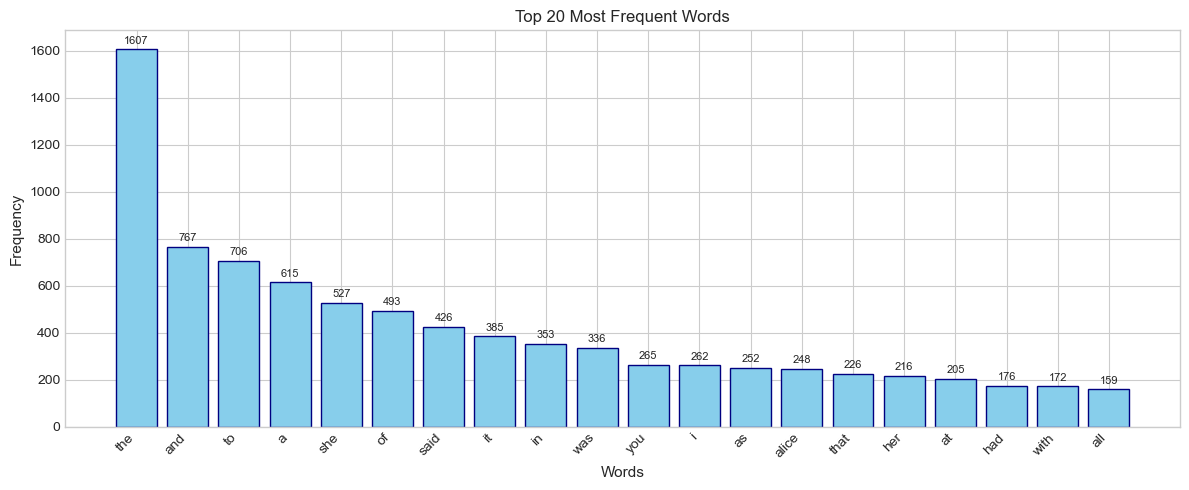

In [4]:
# Visualize word frequency distribution
plot_frequency_distribution(tokens, top_n=20)

## Part 2: Understanding N-grams

N-grams are sequences of N consecutive tokens. They form the foundation of statistical language models.

- **Unigram** (n=1): Individual words
- **Bigram** (n=2): Pairs of consecutive words
- **Trigram** (n=3): Triplets of consecutive words

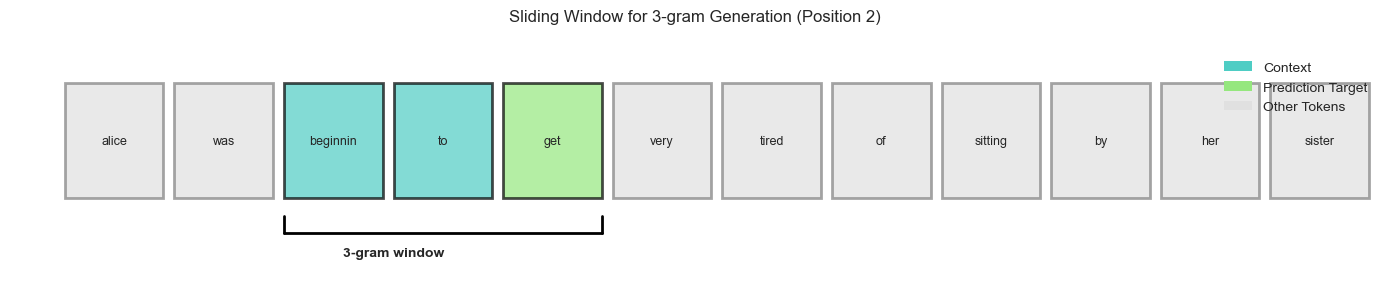

In [5]:
# Visualize how n-grams are extracted using a sliding window
sample_text = "alice was beginning to get very tired of sitting by her sister"
visualize_sliding_window(sample_text, n=3, position=2)

In [6]:
# Generate different types of n-grams
sample_tokens = tokens[:100]

unigrams = generate_ngrams(sample_tokens, 1)
bigrams = generate_ngrams(sample_tokens, 2)
trigrams = generate_ngrams(sample_tokens, 3)

print("Example unigrams:", unigrams[:5])
print("Example bigrams:", bigrams[:5])
print("Example trigrams:", trigrams[:5])

Example unigrams: [("alice's",), ('adventures',), ('in',), ('wonderland',), ('by',)]
Example bigrams: [("alice's", 'adventures'), ('adventures', 'in'), ('in', 'wonderland'), ('wonderland', 'by'), ('by', 'lewis')]
Example trigrams: [("alice's", 'adventures', 'in'), ('adventures', 'in', 'wonderland'), ('in', 'wonderland', 'by'), ('wonderland', 'by', 'lewis'), ('by', 'lewis', 'carroll')]


### Interactive Exercise 1: Predict the Next Word

Before we build our model, try to predict what word might follow these contexts:
1. "the cat"
2. "alice was"
3. "in the"

Think about your predictions, then run the next cells to see what the model finds!

## Part 3: Building N-gram Language Models

Now let's build actual language models and see how well they predict the next word.

In [ ]:
# Split data into training and test sets
split_point = int(len(tokens) * 0.8)
train_tokens = tokens[:split_point]
test_tokens = tokens[split_point:]

print(f"Training tokens: {len(train_tokens)}")
print(f"Test tokens: {len(test_tokens)}")

In [8]:
# Build unigram, bigram, and trigram models
print("Building language models...")

unigram_model = build_ngram_model(train_tokens, 1)
bigram_model = build_ngram_model(train_tokens, 2)
trigram_model = build_ngram_model(train_tokens, 3)

print(f"Unigram contexts: {len(unigram_model)}")
print(f"Bigram contexts: {len(bigram_model)}")
print(f"Trigram contexts: {len(trigram_model)}")

Building language models...
Unigram contexts: 1
Bigram contexts: 3980
Trigram contexts: 13860


In [9]:
# Convert to probability models
unigram_probs = calculate_probabilities(unigram_model)
bigram_probs = calculate_probabilities(bigram_model)
trigram_probs = calculate_probabilities(trigram_model)

print("Probability models created!")

Probability models created!


### Exploring Model Predictions

Let's see what our models predict for different contexts:

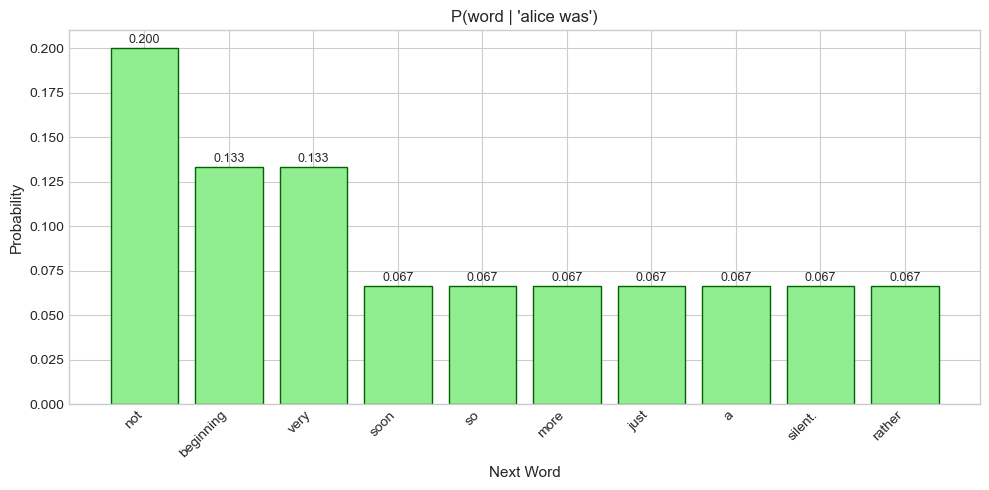

In [10]:
# Check predictions for "alice was"
context = ('alice', 'was')
if context in trigram_probs:
    plot_ngram_probabilities(trigram_probs, context, top_n=10)
else:
    # Try bigram instead
    context = ('alice',)
    if context in bigram_probs:
        plot_ngram_probabilities(bigram_probs, context, top_n=10)

## Part 4: Text Generation

Now let's use our models to generate new text!

In [11]:
# Generate text with different models
seed = "alice was"

print("=== Text Generation ===")
print(f"Seed text: '{seed}'\n")

print("Unigram generation:")
print(generate_text(unigram_probs, 1, seed, length=15))
print()

print("Bigram generation:")
print(generate_text(bigram_probs, 2, seed, length=15))
print()

print("Trigram generation:")
print(generate_text(trigram_probs, 3, seed, length=15))

=== Text Generation ===
Seed text: 'alice was'

Unigram generation:
alice was alice apples, the at it to it to-day?' cat, and round it will 'we're the

Bigram generation:
alice was no time they all she came upon a moment alice was thinking of?' 'i don't

Trigram generation:
alice was just possible it had a head unless there was no label this time there were


### Discussion Point

Notice how the generated text becomes more coherent as we increase n:
- **Unigram**: Random words, no context
- **Bigram**: Some local coherence
- **Trigram**: Better sentence structure

## Part 5: Smoothing Techniques

One problem with n-gram models is **zero probabilities** for unseen n-grams. Smoothing techniques address this issue.

In [12]:
# Demonstrate the zero probability problem
test_context = ('the', 'purple')
test_word = 'elephant'

print(f"Looking for trigram: '{' '.join(test_context + (test_word,))}'")
print(f"Context '{' '.join(test_context)}' exists in model: {test_context in trigram_probs}")

if test_context in trigram_probs:
    if test_word in trigram_probs[test_context]:
        print(f"Probability: {trigram_probs[test_context][test_word]:.4f}")
    else:
        print(f"Word '{test_word}' never seen after this context!")
else:
    print("Context never seen in training data!")

Looking for trigram: 'the purple elephant'
Context 'the purple' exists in model: False
Context never seen in training data!


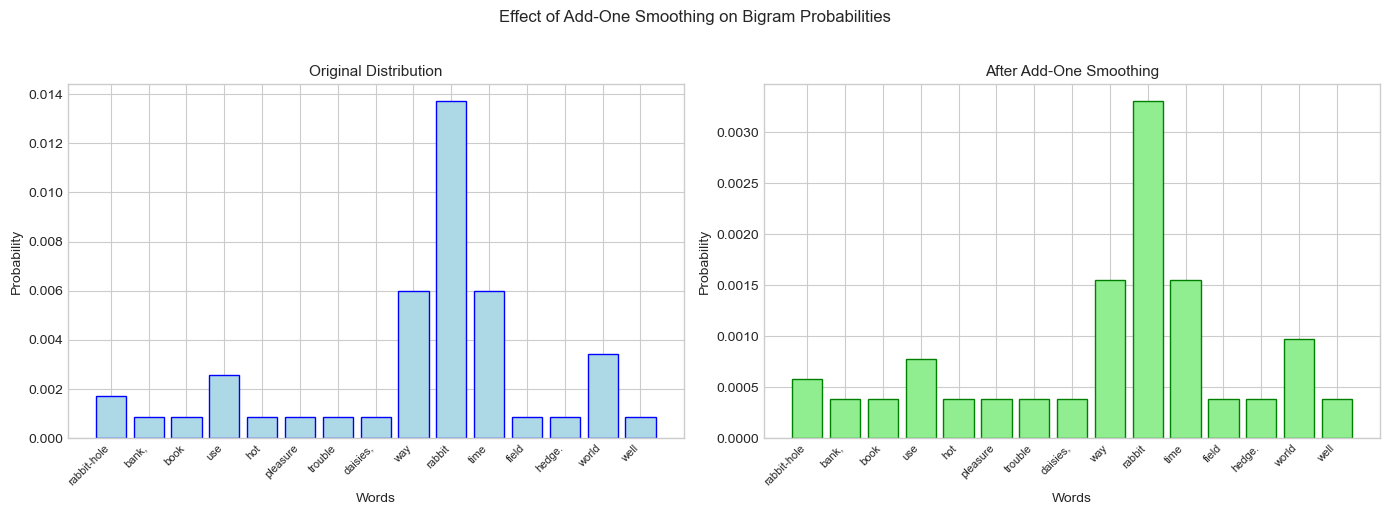

In [13]:
# Apply Add-One (Laplace) smoothing
bigram_smoothed = calculate_probabilities(bigram_model, smoothing='add-one')

# Compare distributions
sample_context = ('the',)
if sample_context in bigram_probs and sample_context in bigram_smoothed:
    visualize_smoothing_effect(
        bigram_probs[sample_context],
        bigram_smoothed[sample_context],
        title="Effect of Add-One Smoothing on Bigram Probabilities"
    )

## Part 6: Model Evaluation with Perplexity

**Perplexity** measures how well a model predicts a test set. Lower perplexity = better model.

Intuitively, perplexity represents the average number of choices the model considers at each step.

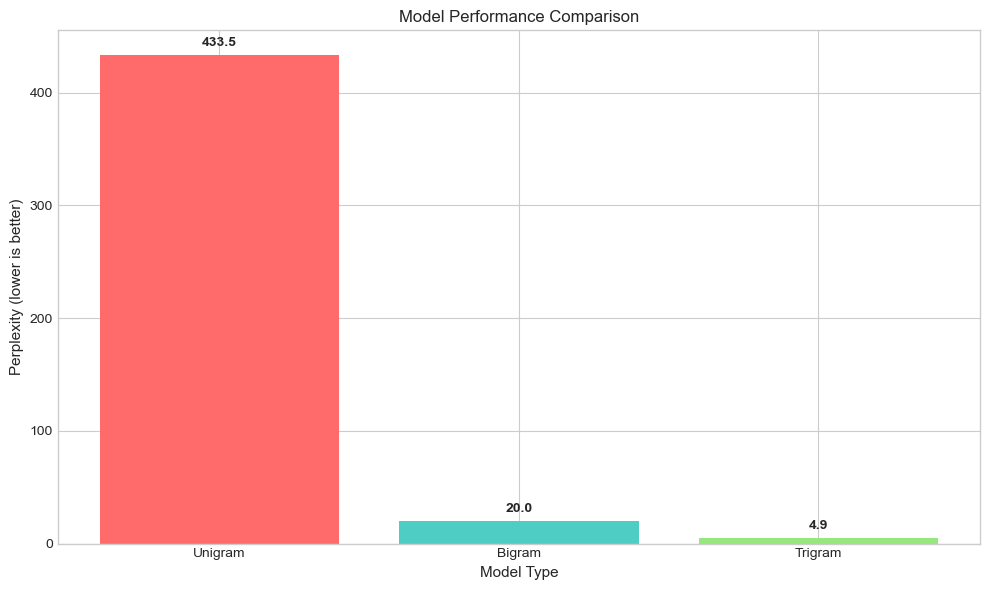


Model Comparison:
  Model  N  Perplexity
Unigram  1  433.507155
 Bigram  2   20.044523
Trigram  3    4.925681


In [14]:
# Calculate perplexity for each model
models = {
    'Unigram': (unigram_probs, 1),
    'Bigram': (bigram_probs, 2),
    'Trigram': (trigram_probs, 3)
}

results_df = compare_models(models, test_tokens[:1000])  # Use subset for faster computation
print("\nModel Comparison:")
print(results_df.to_string(index=False))

## Part 7: Practical Application - Simple Autocomplete

Let's build a simple autocomplete system using our n-gram model!

In [15]:
def autocomplete(model, text, n, num_suggestions=5):
    """Simple autocomplete using n-gram model"""
    tokens = text.lower().split()
    
    if n > 1:
        context = tuple(tokens[-(n-1):])
    else:
        context = ()
    
    if context in model:
        suggestions = sorted(model[context].items(), key=lambda x: x[1], reverse=True)
        return [word for word, _ in suggestions[:num_suggestions]]
    else:
        return ["No suggestions available"]

# Try autocomplete
test_phrases = [
    "alice was",
    "the white",
    "down the",
    "she said"
]

print("=== Autocomplete Demo (using trigram model) ===")
for phrase in test_phrases:
    suggestions = autocomplete(trigram_probs, phrase, 3, num_suggestions=5)
    print(f"\n'{phrase}' ->")
    for i, suggestion in enumerate(suggestions, 1):
        print(f"  {i}. {phrase} {suggestion}")

=== Autocomplete Demo (using trigram model) ===

'alice was' ->
  1. alice was not
  2. alice was beginning
  3. alice was very
  4. alice was soon
  5. alice was so

'the white' ->
  1. the white rabbit
  2. the white rabbit,
  3. the white kid

'down the' ->
  1. down the rabbit-hole
  2. down the middle,
  3. down the hall.
  4. down the bottle,
  5. down the chimney?--nay,

'she said' ->
  1. she said to
  2. she said this,
  3. she said the
  4. she said aloud.
  5. she said this


## Part 8: Exploring Different Text Genres

Language models capture the style of their training data. Let's create a simple comparison:

In [16]:
# Create a formal text sample for comparison
formal_text = """The implementation of natural language processing systems requires careful consideration
of statistical methods. The probability distribution of word sequences provides valuable insights
into linguistic patterns. Furthermore, the application of smoothing techniques ensures robust
performance across diverse datasets. The evaluation metrics, particularly perplexity, indicate
the model's predictive capabilities. Research demonstrates that higher-order n-gram models
generally achieve superior performance. However, computational complexity increases substantially
with larger values of n. Therefore, practitioners must balance model sophistication with
practical constraints. The field continues to evolve with neural approaches."""

# Preprocess and build model for formal text
formal_tokens = preprocess_text(formal_text)
formal_bigram_model = build_ngram_model(formal_tokens, 2)
formal_bigram_probs = calculate_probabilities(formal_bigram_model)

# Generate text in both styles
print("=== Style Comparison ===")
print("\nAlice in Wonderland style:")
print(generate_text(bigram_probs, 2, "the", length=20))

print("\nFormal academic style:")
print(generate_text(formal_bigram_probs, 2, "the", length=20))

=== Style Comparison ===

Alice in Wonderland style:
the gryphon and alice said in same height to go splashing about here, and finding morals in the sage, as all

Formal academic style:
the probability distribution of n. therefore, practitioners must balance model sophistication with larger values of n. therefore, practitioners must balance model


## Part 9: Write Your Own Alice in Wonderland Story

Now for the creative part! Let's use our trained n-gram models to generate our own Alice-style stories. The model has learned the writing patterns from the original text, and we can use it to create new adventures.

### Step 1: Choose Your Story Style

We have three different story templates to choose from:

In [17]:
# Explore available story templates
templates = create_story_template()

print("Available Story Styles:")
print("="*50)
for style, structure in templates.items():
    print(f"\n{style.upper()} STORY:")
    print(f"  Beginning: {structure['beginning'][0]}...")
    print(f"  Middle: {structure['middle'][0]}...")
    print(f"  Climax: {structure['climax'][0]}...")
    print(f"  Ending: {structure['ending'][0]}...")

Available Story Styles:

ADVENTURE STORY:
  Beginning: alice found herself...
  Middle: but then...
  Climax: at last...
  Ending: and so alice...

NONSENSE STORY:
  Beginning: in a world where...
  Middle: which meant that...
  Climax: until suddenly...
  Ending: and that is why...

DREAM STORY:
  Beginning: alice dreamed...
  Middle: everything changed when...
  Climax: suddenly she realized...
  Ending: she woke up...


### Step 2: Generate Your First Story

Let's generate a complete story using our trigram model. The story will follow the classic story structure with a beginning, middle, climax, and ending.

In [18]:
# Generate your first Alice-style story
print("Generating an Alice in Wonderland style story...\n")
print("="*60)

my_story = generate_full_story(
    trigram_probs, 
    n=3, 
    paragraphs=5,  # Number of paragraphs
    style="dream",  # Try: "adventure", "nonsense", or "dream"
    title="Alice's N-gram Adventure"
)

print(my_story)

Generating an Alice in Wonderland style story...

**Alice's N-gram Adventure**


alice dreamed 'we larger eat replied, as in and at once but, alas for poor alice! poor alice! poor alice! it was all dark overhead before her was another puzzling question and as alice could see it quite plainly through the door, and knocked.

everything changed when crowd as i get somewhere,' alice added as an explanation. an explanation. an explanation. an explanation.

"You deserved to be listening, so she turned to the croquet-ground." said Caterpillar.

everything changed when the procession came opposite to alice, very earnestly. very earnestly. very earnestly. very earnestly.

then she found she had forgotten the words. the words. the words. the words.

suddenly she realized another liked bit look! now even it size 'have piece knew, low-spirited. knew, low-spirited. knew, low-spirited.

and then alice put down her flamingo, and began whistling. began whistling.


### Step 3: Analyze Your Generated Story

Let's visualize the structure and characteristics of our generated story:

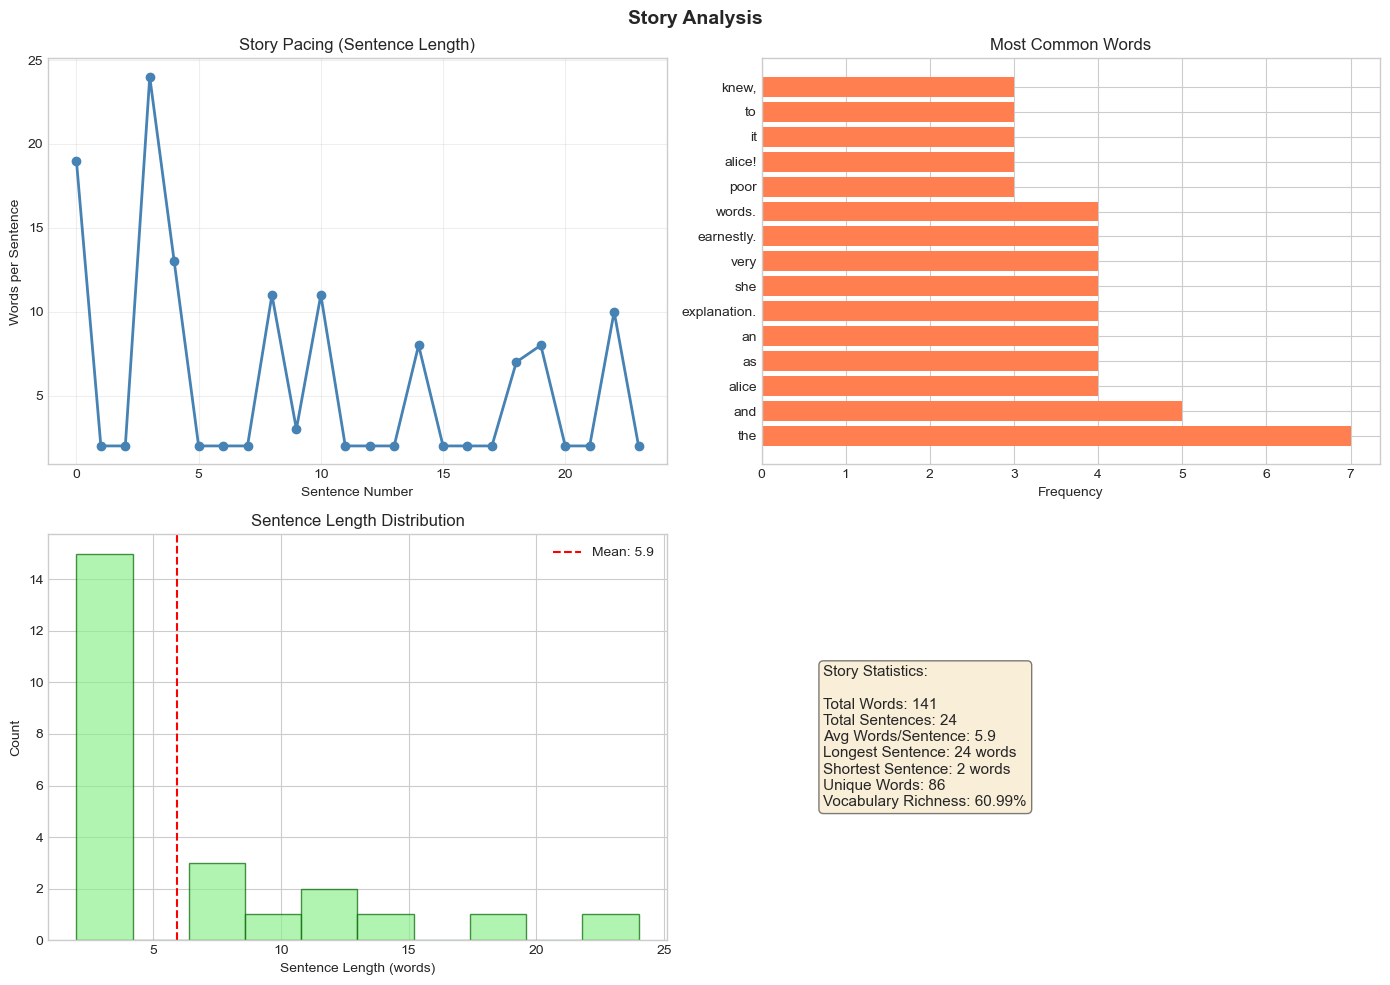

In [19]:
# Analyze the generated story structure
visualize_story_structure(my_story)

### Step 4: Compare Different Story Styles

Let's generate stories in all three styles and see how they differ:

In [20]:
# Generate stories in different styles
stories = compare_story_styles(trigram_probs, n=3)

print("\n" + "="*60)
print("STORY COMPARISON")
print("="*60)

for style, story in stories.items():
    print(f"\n{style.upper()} STYLE:")
    print("-"*40)
    # Print just the first paragraph of each for comparison
    first_paragraph = story.split('\n\n')[1] if '\n\n' in story else story[:200]
    print(first_paragraph)
    print()

Generating adventure story...
Generating nonsense story...
Generating dream story...

STORY COMPARISON

ADVENTURE STYLE:
----------------------------------------

alice found herself safe in a coaxing tone, and added with a deep sigh, 'i was a good deal to me,' said alice in a hoarse growl, 'the. growl, 'the. growl, 'the.


NONSENSE STYLE:
----------------------------------------

there once was a dead silence instantly, and neither of the leaves 'i should like to be listening, so she went to the little golden key, and when? and when? and when? the tumbling came game,' you the advisable--"' matters 'but a grin without a grin,' thought alice 'but a grin without a cat!


DREAM STYLE:
----------------------------------------

she imagined try on off better be least--at little i've 'two shyly, idea these am i'm patriotic would her, shall my here,' put she alice, said sort. said sort. said sort.



### Step 5: Interactive Story Building

Now let's build a story interactively, paragraph by paragraph. You can guide the story direction!

In [21]:
# Interactive story building - modify these starters!
print("BUILD YOUR OWN ALICE STORY")
print("="*60)
print("Modify the story_starters below to guide your story:\n")

# You can modify these to create your own story!
story_starters = [
    "alice found herself",     # Beginning
    "suddenly the queen",       # Introduce conflict
    "but then alice",          # Alice's response
    "finally she realized"     # Resolution
]

interactive_story = []
for i, starter in enumerate(story_starters):
    print(f"\n--- Paragraph {i+1} (Starting with: '{starter}') ---")
    paragraph = generate_paragraph(trigram_probs, 3, starter, sentences=3)
    interactive_story.append(paragraph)
    print(paragraph)

print("\n" + "="*60)
print("YOUR COMPLETE STORY:")
print("="*60)
print('\n'.join(interactive_story))

BUILD YOUR OWN ALICE STORY
Modify the story_starters below to guide your story:


--- Paragraph 1 (Starting with: 'alice found herself') ---
alice found herself in the sea!' cried the mouse, getting up and rubbed its eyes again, to see the queen. the queen. the queen.

--- Paragraph 2 (Starting with: 'suddenly the queen') ---
suddenly the queen had only one who had been to the mock turtle, who looked at alice, and she hastily put down her anger as well go in? go in? that middle, dull! middle, dull! in over move him, on clearly,' game,' away!' else.

--- Paragraph 3 (Starting with: 'but then alice') ---
but then alice dodged behind a great deal too far off to trouble myself about you you must manage the best of educations--in fact, we went to work. to work. to work.

--- Paragraph 4 (Starting with: 'finally she realized') ---
finally she realized if archbishop the be a great interest in questions of eating and drinking. and drinking. and drinking.

YOUR COMPLETE STORY:
alice found herse

### Step 6: Add Character Dialogue

Stories become more engaging with dialogue. Let's generate some character conversations:

In [22]:
# Generate dialogue between characters
print("ALICE IN WONDERLAND DIALOGUE GENERATOR")
print("="*60)

# Find available characters in our model
characters = get_character_names(trigram_probs)
print(f"Available characters: {', '.join(characters[:10])}\n")

# Generate a conversation
print("A Tea Party Conversation:")
print("-"*40)

emotions = ["said", "exclaimed", "whispered", "shouted", "asked", "replied"]

for i in range(6):
    character = random.choice(characters[:5]) if len(characters) >= 5 else "Alice"
    emotion = random.choice(emotions)
    dialogue = generate_dialogue(trigram_probs, 3, character, emotion)
    print(dialogue)
    print()

# Create a riddle scene
print("\nA Riddling Conversation:")
print("-"*40)
riddle_starters = ["why is", "what is", "how can", "where does"]
for starter in riddle_starters[:2]:
    riddle = generate_sentence(trigram_probs, 3, starter, max_length=15)
    print(f'"{ riddle}" asked the Hatter.')
    
    # Generate Alice's response
    response = generate_sentence(trigram_probs, 3, "i don't", max_length=12)
    print(f'"{ response}" replied Alice.\n')

ALICE IN WONDERLAND DIALOGUE GENERATOR
Available characters: Turtle, Alice, Hatter, Queen, King, Mouse, Dormouse, Rabbit, Caterpillar, Duchess

A Tea Party Conversation:
----------------------------------------
"What in had and as alice could bear she got used to read fairy-tales, i fancied?" asked King.

"Why into its eyes again, to see if she was so small as this is the?" shouted Alice.

"What person, you the minute." shouted Alice.

"What 'ah, would it." whispered Queen.

"What a delightful thing a bit!' said the gryphon." whispered Turtle.

"Why saw won't ringlets only but she could do, lying down with one eye but to?" exclaimed Hatter.


A Riddling Conversation:
----------------------------------------
"why is the capital of paris, and paris is the capital of paris, and paris is the?" asked the Hatter.
"i don't care which happens!" replied Alice.

"what is the capital of paris, and paris is the reason so many lessons to learn!" asked the Hatter.
"i don't remember where." replied A

### Step 7: Creative Challenge - Write About a New Wonderland Creature

Use the model to describe a new creature Alice might meet in Wonderland:

In [23]:
# Create a new Wonderland creature
print("CREATE YOUR OWN WONDERLAND CREATURE")
print("="*60)

# Modify these to create your own creature!
creature_name = "Purple Jabberwock"  # Change this!
creature_traits = [
    "with three heads",
    "who spoke in riddles",
    "and loved to dance"
]

print(f"\nIntroducing: The {creature_name}")
print("-"*40)

# Generate the creature's introduction
intro = f"alice met a {creature_name.lower()}"
creature_intro = generate_paragraph(trigram_probs, 3, intro, sentences=3)
print(creature_intro)

# Generate what the creature says
print(f"\nThe {creature_name} speaks:")
print("-"*40)
for _ in range(3):
    creature_speech = generate_dialogue(trigram_probs, 3, creature_name, "said")
    print(creature_speech)

# Generate Alice's reaction
print("\nAlice's reaction:")
print("-"*40)
reaction = generate_paragraph(trigram_probs, 3, "alice thought this", sentences=2)
print(reaction)

CREATE YOUR OWN WONDERLAND CREATURE

Introducing: The Purple Jabberwock
----------------------------------------
alice met a purple jabberwock she sure! she sure! she sure!

The Purple Jabberwock speaks:
----------------------------------------
"Why gryphon, fun?" said Purple Jabberwock.
"Why dipped was 'i'd as like timidly is 'i eat much very chose both now said?" said Purple Jabberwock.
"But pause hair be as well as she said to herself, as she stood looking at." said Purple Jabberwock.

Alice's reaction:
----------------------------------------
alice thought this a very difficult game indeed. game indeed.


### Discussion: What Makes the Stories "Alice-like"?

Notice how the generated stories capture certain characteristics of the original Alice in Wonderland:

1. **Vocabulary**: The model uses words frequently found in the original text
2. **Sentence Structure**: The rhythm and flow mirror Carroll's writing style  
3. **Character References**: Familiar characters appear naturally
4. **Whimsical Logic**: The nonsensical yet structured narrative

However, also notice the limitations:
- **Local Coherence**: Sentences connect locally but may lose global coherence
- **Repetition**: Common phrases may repeat too often
- **Limited Context**: The model can't maintain long-term plot consistency

### Your Turn: Experiment!

Try these experiments:
1. Change the n-gram order (use bigram vs trigram) and compare story quality
2. Modify the story starters to create different narratives
3. Combine different models (e.g., use trigram for narrative, bigram for dialogue)
4. Train on a different text and see how the style changes!

Remember: N-gram models are statistical - they learn patterns but don't truly "understand" the story. This is why modern NLP has moved to neural models that can capture deeper meaning!

## Exercises for Further Practice

### Exercise 1: Character-level Language Model
Modify the code to build a character-level model instead of word-level. What differences do you observe?

### Exercise 2: Backoff Strategy
Implement a backoff strategy: use trigram if available, otherwise bigram, otherwise unigram.

### Exercise 3: Cross-Domain Evaluation
Train a model on one genre (e.g., fiction) and evaluate on another (e.g., news). What happens to perplexity?

### Exercise 4: Optimize Hyperparameters
Experiment with different smoothing parameters (alpha values) to minimize perplexity on a validation set.

## Summary and Key Takeaways

In this notebook, you've learned:

1. **N-gram Models**: Statistical models that predict words based on previous context
2. **Probability Estimation**: Converting frequency counts to probabilities
3. **Smoothing**: Handling unseen n-grams to avoid zero probabilities
4. **Perplexity**: Evaluating model quality on test data
5. **Applications**: Text generation and autocomplete

### Limitations of N-gram Models:
- Limited context window (can't capture long-range dependencies)
- Data sparsity for higher-order n-grams
- No semantic understanding
- Storage requirements grow exponentially with n

### Next Steps:
In upcoming weeks, we'll explore neural language models that address these limitations!

In [24]:
# Final interactive demo: Build your own model
print("Experiment with your own text!")
print("Try changing the parameters below:")

# You can modify these parameters
your_text = """The quick brown fox jumps over the lazy dog.
The dog was sleeping under the tree.
The fox ran quickly through the forest.
The brown fox was very clever."""

n_value = 2  # Try 1, 2, or 3
seed_text = "the"

# Build and test your model
your_tokens = preprocess_text(your_text)
your_model = build_ngram_model(your_tokens, n_value)
your_probs = calculate_probabilities(your_model, smoothing='add-one')

print(f"\nGenerated text ({n_value}-gram model):")
print(generate_text(your_probs, n_value, seed_text, length=15))

Experiment with your own text!
Try changing the parameters below:

Generated text (2-gram model):
the dog was very clever. tree. the tree. the fox ran quickly through the lazy dog.


## Part 10: Writing Shakespeare Sonnets with N-grams

Now let's explore a completely different literary style! We'll train our n-gram model on Shakespeare's text and generate our own sonnets. This demonstrates how n-gram models adapt to different writing styles and structures.

### What is a Shakespearean Sonnet?

A Shakespearean sonnet has:
- **14 lines** total
- **Iambic pentameter** (10 syllables per line, with alternating unstressed/stressed pattern)
- **Rhyme scheme**: ABAB CDCD EFEF GG
- **Structure**: 3 quatrains (4-line stanzas) + 1 couplet (2 lines)
- **Turn**: Often a shift in thought at line 9 or in the final couplet

### Step 1: Load Shakespeare Text

In [25]:
# Download Shakespeare text
shakespeare_text = download_shakespeare_sonnets()

print(f"Shakespeare text length: {len(shakespeare_text)} characters")
print(f"\nFirst 500 characters:")
print(shakespeare_text[:500])

Downloaded Shakespeare text from NLTK Gutenberg corpus
Shakespeare text length: 162881 characters

First 500 characters:
[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco

   Fran. For this releefe much thankes: 'Tis bitter cold,
And I am sicke at heart

   Barn. Haue you had quiet Guard?
  Fran. Not


In [26]:
# Build Shakespeare n-gram models
shakespeare_tokens = preprocess_text(shakespeare_text)

print(f"Total Shakespeare tokens: {len(shakespeare_tokens)}")
print(f"Unique tokens: {len(set(shakespeare_tokens))}")

# Split for training
shakespeare_split = int(len(shakespeare_tokens) * 0.8)
shakespeare_train = shakespeare_tokens[:shakespeare_split]
shakespeare_test = shakespeare_tokens[shakespeare_split:]

# Build models
print("\nBuilding Shakespeare language models...")
shakespeare_bigram_model = build_ngram_model(shakespeare_train, 2)
shakespeare_trigram_model = build_ngram_model(shakespeare_train, 3)

# Convert to probabilities
shakespeare_bigram_probs = calculate_probabilities(shakespeare_bigram_model, smoothing='add-one')
shakespeare_trigram_probs = calculate_probabilities(shakespeare_trigram_model, smoothing='add-one')

print(f"Shakespeare bigram contexts: {len(shakespeare_bigram_model)}")
print(f"Shakespeare trigram contexts: {len(shakespeare_trigram_model)}")

Total Shakespeare tokens: 29580
Unique tokens: 6238

Building Shakespeare language models...
Shakespeare bigram contexts: 5296
Shakespeare trigram contexts: 18195


### Step 2: Compare Literary Styles

Let's see how Shakespeare's language differs from Alice in Wonderland:

In [27]:
# Compare the two literary styles
print("LITERARY STYLE COMPARISON")
print("="*60)

style_comparison = compare_literary_styles(trigram_probs, shakespeare_trigram_probs, 3)

for prompt, texts in style_comparison.items():
    print(f"\nStarting with '{prompt}':")
    print("-"*40)
    print(f"Alice style: {texts['alice'][:80]}...")
    print(f"Shakespeare: {texts['shakespeare'][:80]}...")

# Compare vocabulary
alice_vocab = set(word for context_dict in trigram_probs.values() for word in context_dict.keys())
shakespeare_vocab = set(word for context_dict in shakespeare_trigram_probs.values() for word in context_dict.keys())

print(f"\n\nVocabulary Statistics:")
print(f"Alice vocabulary size: {len(alice_vocab)}")
print(f"Shakespeare vocabulary size: {len(shakespeare_vocab)}")
print(f"Shared words: {len(alice_vocab.intersection(shakespeare_vocab))}")
print(f"Alice-only words: {len(alice_vocab - shakespeare_vocab)}")
print(f"Shakespeare-only words: {len(shakespeare_vocab - alice_vocab)}")

LITERARY STYLE COMPARISON

Starting with 'the':
----------------------------------------
Alice style: the out and it was so long since she had not attended to this last remark,...
Shakespeare: the enseamed are reuerted vs what this shew imports the argument of the ayre my ...

Starting with 'when i':
----------------------------------------
Alice style: when i used to come once a week he taught us,' said the youth, 'one would hardly...
Shakespeare: when i said, man delights not me? rosin. to visit my too much of this. there is...

Starting with 'but':
----------------------------------------
Alice style: but an she should meet the real mary ann, and be turned out of sight, they...
Shakespeare: but me for a state, and keepe within the center king. how is it not perdie....

Starting with 'and yet':
----------------------------------------
Alice style: and yet you incessantly stand on their faces, so that altogether, for the first ...
Shakespeare: and yet to me speak to me. if thou wilt n

### Step 3: Generate Individual Sonnet Components

Before creating a full sonnet, let's practice generating individual components:

In [28]:
# Generate single iambic lines
print("GENERATING IAMBIC LINES")
print("="*60)
print("Target: ~10 syllables per line (iambic pentameter)")
print("-"*40)

for i in range(5):
    line = generate_iambic_line(shakespeare_trigram_probs, 3)
    syllables = sum(count_syllables(word) for word in line.split())
    print(f"{i+1}. {line}")
    print(f"   ({syllables} syllables)")
    print()

# Generate rhyming pairs
print("\nGENERATING RHYMING COUPLETS")
print("="*60)

for i in range(3):
    line1, line2 = find_rhyme_pair(shakespeare_trigram_probs, 3)
    print(f"Couplet {i+1}:")
    print(f"  {line1}")
    print(f"  {line2}")
    print()

# Generate a quatrain
print("\nGENERATING QUATRAIN (ABAB)")
print("="*60)
quatrain = generate_quatrain(shakespeare_trigram_probs, 3, "ABAB")
for i, line in enumerate(quatrain):
    rhyme_label = "ABAB"[i]
    print(f"{rhyme_label}: {line}")
print()

GENERATING IAMBIC LINES
Target: ~10 syllables per line (iambic pentameter)
----------------------------------------
1. and doth against not him an walke
   (8 syllables)

2. and might do dish manner you said
   (8 syllables)

3. thy all goe his soule may be well
   (8 syllables)

4. when whether as of a choppine
   (8 syllables)

5. though soule soule the go euen my gentle thou poore
   (10 syllables)


GENERATING RHYMING COUPLETS
Couplet 1:
  yet forehead it the king? hor
  but know not but in battalians

Couplet 2:
  yet for no a i and if there might
  thy his booke father bee that come i lord moult

Couplet 3:
  yet courses my he of gentleman bestow'd
  thou and part you, as your daughter may hard


GENERATING QUATRAIN (ABAB)
A: if none instantly king, none him ham
B: but no tongue i will vse no art
A: yet may and as i hold my dutie
B: if we would, or if thou art to thy father



### Step 4: Generate Your First Complete Sonnet!

In [29]:
# Generate a complete Shakespearean sonnet!
print("GENERATING COMPLETE SONNET")
print("="*60)
print("Theme: Love (classic Shakespearean theme)")
print()

# Generate the sonnet
sonnet_lines = generate_sonnet(shakespeare_trigram_probs, 3, theme="love")

# Format and display
my_sonnet = format_sonnet(sonnet_lines, title="Sonnet I: An N-gram Love")
print(my_sonnet)

GENERATING COMPLETE SONNET
Theme: Love (classic Shakespearean theme)

Generating first quatrain...
Generating second quatrain...
Generating third quatrain...
Generating final couplet...
**Sonnet I: An N-gram Love**

if to world as these come, night
but death father, a'th' of eares
for blacke needs like me aye are sacred by toyle
if my loue is, proofe hath made him mornings

and you make of me this not to wittenberg ham
and ile be reueng'd most throughly for my meanes
if we list to speake with you in her owne them
and would'st for his passage? no

for so i alone became their prisoner
and make your wantonnesse, your ignorance
but father haue or delights danish another
shall this bloody deede be answered? it will wherefore

when see could had on touch king hide laugh
thy do't to vp francisco where he besmerch



### Step 5: Analyze Sonnet Structure

Let's analyze how well our generated sonnet follows traditional structure:

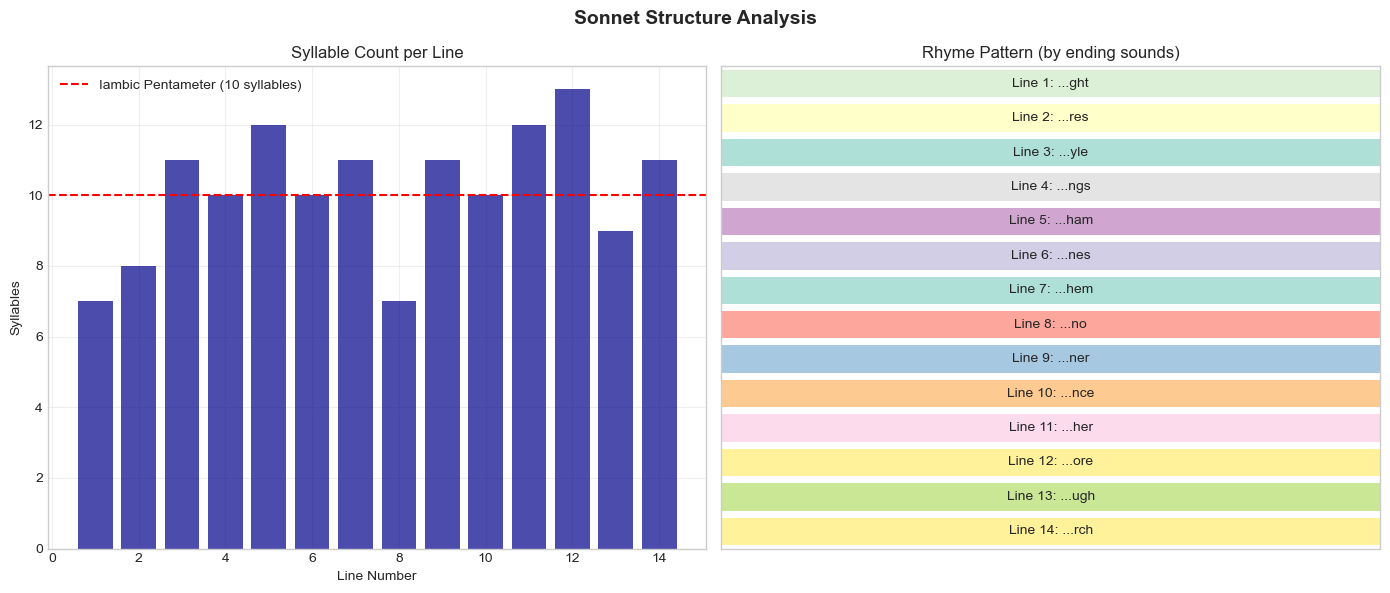

Average syllables per line: 10.1
Total lines: 14
Lines close to iambic pentameter (9-11 syllables): 8/14


In [30]:
# Analyze the sonnet structure
visualize_sonnet_analysis(my_sonnet)

### Step 6: Generate Themed Sonnets

Shakespeare wrote about various themes. Let's generate sonnets on different topics:

In [31]:
# Generate sonnets on different themes
themes = ["time", "nature", "mortality"]

for theme in themes:
    print(f"\nGENERATING {theme.upper()} SONNET")
    print("="*60)
    
    # Generate sonnet
    theme_sonnet_lines = generate_sonnet(shakespeare_trigram_probs, 3, theme=theme)
    
    # Format and display (just show first 4 lines and last 2)
    print(f"\n**Sonnet: On {theme.capitalize()}**\n")
    print("First quatrain:")
    for i in range(4):
        print(f"  {theme_sonnet_lines[i]}")
    print("\n  [...]")
    print("\nFinal couplet:")
    for i in range(12, 14):
        if i < len(theme_sonnet_lines):
            print(f"  {theme_sonnet_lines[i]}")
    print()


GENERATING TIME SONNET
Generating first quatrain...
Generating second quatrain...
Generating third quatrain...
Generating final couplet...

**Sonnet: On Time**

First quatrain:
  if hamlet returnes, shooes, with gho
  yet no wary and would of an enseamed bed
  thou againe the doe, whose the mornings
  though and thus the glimpses of the hard

  [...]

Final couplet:
  though persons of with or madnesse
  shall in all denmarke but hee's an arrant knaue hor


GENERATING NATURE SONNET
Generating first quatrain...
Generating second quatrain...
Generating third quatrain...
Generating final couplet...

**Sonnet: On Nature**

First quatrain:
  though partiall, most let you know of it they trauaile
  when friends lacke my england, the they to mars, they
  if slaue makes of so sweet breath compos'd
  if what what so, your obseruers, carry

  [...]

Final couplet:
  shall againe the but and sober, it dar'st hamlet
  shall in all i shall th' effect of this barn


GENERATING MORTALITY SONNET
Gene

### Step 7: Interactive Sonnet Builder

Create your own customized sonnet by modifying the parameters below:

In [32]:
# INTERACTIVE SONNET BUILDER
print("BUILD YOUR OWN SHAKESPEAREAN SONNET")
print("="*60)
print("Customize the parameters below to create your unique sonnet!")
print()

# Customize these parameters!
your_theme = "love"  # Options: "love", "time", "nature", "mortality"
your_title = "My N-gram Sonnet"
opening_words = "shall i"  # Start your sonnet with these words

# Build a custom sonnet with specific opening
print(f"Creating sonnet with theme: {your_theme}")
print(f"Opening with: '{opening_words}...'")
print()

# Generate with custom opening
custom_lines = []

# First line with custom opening
first_line = generate_text(shakespeare_trigram_probs, 3, opening_words, length=10)
# Clean it up to approximate iambic pentameter
first_words = first_line.split()[:8]  # Limit to ~10 syllables
custom_lines.append(' '.join(first_words))

# Generate rest of first quatrain
for i in range(3):
    custom_lines.append(generate_iambic_line(shakespeare_trigram_probs, 3))

# Generate remaining quatrains and couplet
for i in range(10):
    custom_lines.append(generate_iambic_line(shakespeare_trigram_probs, 3))

# Format and display
custom_sonnet = format_sonnet(custom_lines, title=your_title)
print(custom_sonnet)

BUILD YOUR OWN SHAKESPEAREAN SONNET
Customize the parameters below to create your unique sonnet!

Creating sonnet with theme: love
Opening with: 'shall i...'

**My N-gram Sonnet**

shall i strike at it with you and
but 'tis not fit thus to obey him hor
when then command the and take demand my minde
thou i thy then hast ring? wore let sonne? graces

for that i did enact iulius caesar
but o to with light, long lord, him
and hath giuen me this now gather, and surmise
thy the deare there me mercy was are players father

thou word, fellowship, or time to acte them in
thou knaue excellent death but guild
though but will plaist'ring thou of himselfe
thou gins giue gawdie beare the whips and scornes of time

but of our demands most free and bounteous
when indeed, the very soule, and there i see ham



### Step 8: Creative Challenge - Mix Literary Styles!

What happens when we mix Shakespeare's structure with Alice's vocabulary? Or vice versa?

In [33]:
# LITERARY STYLE MASHUP!
print("MIXING LITERARY STYLES")
print("="*60)

# Generate a "Shakespearean" sonnet using Alice vocabulary
print("\n1. ALICE IN SONNET FORM")
print("-"*40)
print("Using Alice's vocabulary in Shakespeare's structure:\n")

alice_sonnet_lines = []
for i in range(14):
    # Use Alice model but try to approximate sonnet length
    line = generate_text(trigram_probs, 3, "the", length=8)
    alice_sonnet_lines.append(line)

alice_as_sonnet = format_sonnet(alice_sonnet_lines, title="Alice's Dream (A Sonnet)")
print(alice_as_sonnet)

# Generate Wonderland-style text using Shakespeare vocabulary  
print("\n2. SHAKESPEARE IN WONDERLAND")
print("-"*40)
print("Shakespeare vocabulary in Alice's whimsical style:\n")

# Use Shakespeare words but Alice-style short sentences
wonderland_shakespeare = []
alice_starters = ["suddenly", "but then", "the queen", "alice thought"]

for starter in alice_starters:
    # Try to find similar starter in Shakespeare
    shakes_sentence = generate_sentence(shakespeare_trigram_probs, 3, starter, max_length=15)
    wonderland_shakespeare.append(shakes_sentence)

print("A Shakespearean Tea Party:")
print()
for sentence in wonderland_shakespeare:
    print(f"  {sentence}")
print()

# Mix vocabularies - alternate between models
print("\n3. TRUE LITERARY FUSION")
print("-"*40)
print("Alternating between both styles line by line:\n")

fusion_lines = []
for i in range(8):
    if i % 2 == 0:
        # Shakespeare line
        line = generate_iambic_line(shakespeare_trigram_probs, 3)
        fusion_lines.append(f"[S] {line}")
    else:
        # Alice line
        line = generate_text(trigram_probs, 3, "alice", length=8)
        fusion_lines.append(f"[A] {line}")

print("The Fusion Poem:")
for line in fusion_lines:
    print(line)

MIXING LITERARY STYLES

1. ALICE IN SONNET FORM
----------------------------------------
Using Alice's vocabulary in Shakespeare's structure:

**Alice's Dream (A Sonnet)**

the she back!' of thought, and looked at poor
the am turtle.' it is, i can't get out
the a underneath wouldn't airs! two he ran you
the that with look this is the capital of

the up could added with a sigh 'it's always
the 'if down the hall. after a few minutes
the hatter grumbled 'you shouldn't have put it more
the prevent children, curious!' window.' you round the table,

the out." far!" day merely if is into alice
the making of minute was voice complained 'are sending
the the first thing i've got to grow up
the no it again. i'm ann, inclined would time

the respectable sky-rocket!' she 'or thought you've to kept
the sitting all,' hear of to told anything short


2. SHAKESPEARE IN WONDERLAND
----------------------------------------
Shakespeare vocabulary in Alice's whimsical style:

A Shakespearean Tea Party:

  s

### Discussion: Comparing Poetic Generation

Notice the differences between our Alice stories and Shakespeare sonnets:

**Shakespeare N-gram Characteristics:**
- More formal, archaic vocabulary ("thee", "thou", "thy")
- Attempts at consistent meter (though imperfect)
- More complex sentence structures
- Poetic devices and imagery

**Alice N-gram Characteristics:**
- Simpler, more modern vocabulary
- Narrative flow and dialogue
- Whimsical, nonsensical elements
- Character-driven content

**Limitations of N-grams for Poetry:**
- **No true understanding of meter** - syllable counting is approximate
- **Rhyme is coincidental** - based on statistical patterns, not sound
- **No semantic coherence** - themes don't develop meaningfully
- **Structure is superficial** - follows form but not function

### Your Turn: Experiments!

1. **Adjust n-gram order**: Try n=2 vs n=3 vs n=4 for sonnets
2. **Mix training data**: Train on both Shakespeare AND Alice together
3. **Constrain vocabulary**: Generate sonnets using only Shakespeare's 100 most common words
4. **Modern sonnets**: Train on contemporary poetry and compare
5. **Reverse engineering**: Can you tell which lines are Shakespeare vs generated?

### Key Takeaway

N-gram models can mimic surface-level style (vocabulary, common phrases) but struggle with deeper structure (meter, rhyme, meaning). This is why modern NLP uses neural networks that can better capture these complex patterns!

The same model architecture (n-grams) produces radically different outputs based on training data, demonstrating that these models are fundamentally **statistical pattern matchers** rather than true language understanders.